In [1]:
import tmdbsimple as tmdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import requests
import configparser
import pickle

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import squareform


In [2]:
config = configparser.ConfigParser()
config.read('API_KEYS.ini')
config.sections()

API_KEY = config['tmdb.com']['API_KEY']

tmdb.API_KEY = API_KEY

In [3]:
genome_tags_ids = pd.read_csv('data/genome-tags.csv')
movies = pd.read_csv('data/movies.csv')
genome_tags = pd.read_csv('data/genome-scores.csv')
user_tags = pd.read_csv('data/tags.csv')
links = pd.read_csv('data/links.csv')

In [4]:
#45843 movies
movies.shape

(45843, 3)

In [5]:
movies = movies.merge(links, left_on = 'movieId', right_on = 'movieId', how = 'left')
movies.dropna(subset=['tmdbId'], inplace=True)
movies['tmdbId'] = movies['tmdbId'].astype(int)
movies.loc[movies['movieId'] == 4207, 'tmdbId'] = 427910
movies.loc[movies['movieId'] == 4568, 'tmdbId'] = 207340
movies.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357
4,5,Father of the Bride Part II (1995),Comedy,113041,11862


In [6]:
movies[movies['tmdbId'] == 17882]

,movieId,title,genres,imdbId,tmdbId


In [7]:
genome_tags = genome_tags.merge(genome_tags_ids, left_on = 'tagId', right_on = 'tagId', how = 'left')
genome_tags = genome_tags.merge(movies[['title', 'movieId', 'tmdbId']], left_on = 'movieId', right_on = 'movieId', how = 'left')
genome_tags = genome_tags[genome_tags['tmdbId'].notnull()]
genome_tags['tmdbId'] = genome_tags['tmdbId'].astype(int)
genome_tags.head()

,movieId,tagId,relevance,tag,title,tmdbId
0,1,1,0.02475,007,Toy Story (1995),862
1,1,2,0.02475,007 (series),Toy Story (1995),862
2,1,3,0.04900,18th century,Toy Story (1995),862
3,1,4,0.07750,1920s,Toy Story (1995),862
4,1,5,0.12450,1930s,Toy Story (1995),862


In [8]:
#Only 10982 movies with genome tags
len(genome_tags['movieId'].unique())

10982

In [9]:
top5 = genome_tags.sort_values(by=['movieId', 'relevance', 'tagId'], ascending = [True, False, True]).groupby('movieId').head(5)
top5.head()

,movieId,tagId,relevance,tag,title,tmdbId
1035,1,1036,0.99925,toys,Toy Story (1995),862
243,1,244,0.99875,computer animation,Toy Story (1995),862
785,1,786,0.99525,pixar animation,Toy Story (1995),862
588,1,589,0.99125,kids and family,Toy Story (1995),862
63,1,64,0.98650,animation,Toy Story (1995),862


[Text(0,0,'computer animation'),
 Text(0,0,'kids and family'),
 Text(0,0,'animation'),
 Text(0,0,'adventure'),
 Text(0,0,'children'),
 Text(0,0,'kids'),
 Text(0,0,'special effects'),
 Text(0,0,'good sequel'),
 Text(0,0,'sequel'),
 Text(0,0,'sequels'),
 Text(0,0,'comedy'),
 Text(0,0,'original'),
 Text(0,0,'women'),
 Text(0,0,'chick flick'),
 Text(0,0,'girlie movie'),
 Text(0,0,'romantic'),
 Text(0,0,'unlikely friendships'),
 Text(0,0,'crime'),
 Text(0,0,'gunfight'),
 Text(0,0,'great acting'),
 Text(0,0,'remake'),
 Text(0,0,'romantic comedy'),
 Text(0,0,'romance'),
 Text(0,0,'based on a book'),
 Text(0,0,'childhood'),
 Text(0,0,'adapted from:book'),
 Text(0,0,'action'),
 Text(0,0,'good action'),
 Text(0,0,'franchise'),
 Text(0,0,'espionage'),
 Text(0,0,'politics'),
 Text(0,0,'political'),
 Text(0,0,'spoof'),
 Text(0,0,'parody'),
 Text(0,0,'silly fun'),
 Text(0,0,'biographical'),
 Text(0,0,'biopic'),
 Text(0,0,'gangsters'),
 Text(0,0,'storytelling'),
 Text(0,0,'weird'),
 Text(0,0,'goofy')

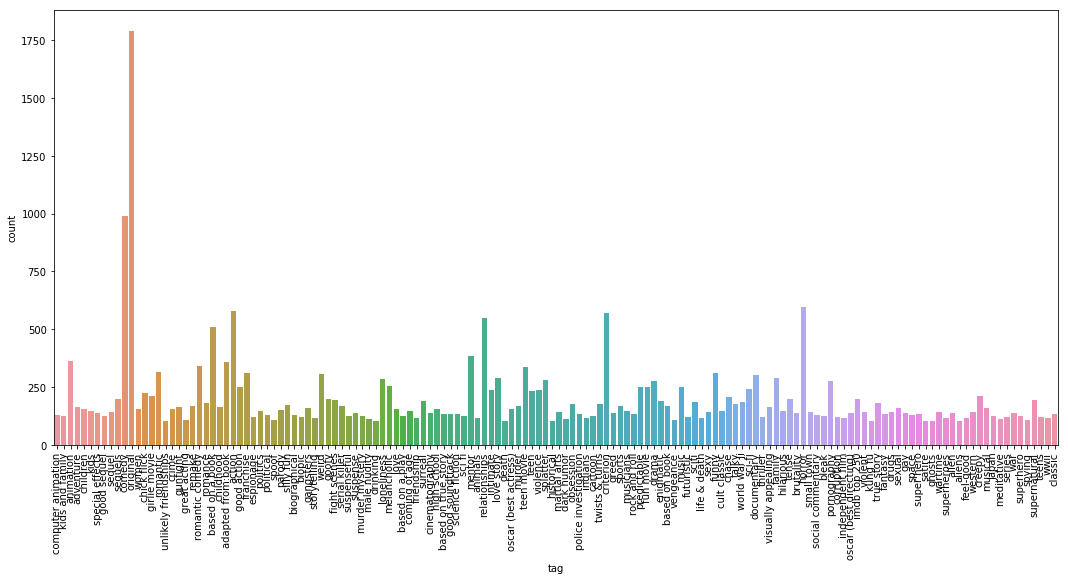

In [10]:
#Get list of top 5 tags
tagslist = top5.tag.value_counts()
tagslist = tagslist[tagslist > 100]
tagslist = list(tagslist.index.values)  

top5 = top5.loc[top5['tag'].isin(tagslist)]

fig, ax = plt.subplots(figsize=(18,8))
ax = sns.countplot(x = "tag", data = top5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [11]:
genome_tags = genome_tags.loc[genome_tags['tag'].isin(tagslist)]
genome_tags = genome_tags.pivot(index='movieId', columns='tag', values='relevance')
genome_tags.columns = map(str.lower, genome_tags.columns)
genome_tags.columns = genome_tags.columns.str.replace(' ', '_')

In [12]:
genome_tags.columns.values

drop_cols = ['adapted_from:book',
             'based_on_a_book', 
             'based_on_a_play',
             'based_on_book', 
             'based_on_true_story', 
             'cinematography', 
             'classic',
             'computer_animation',
             'criterion', 
             'cult_classic',
             'franchise', 
             'good_sequel', 
             'good_soundtrack',
             'great_acting',
             'imdb_top_250', 
             'male_nudity', 
             'original',
             'oscar_(best_actress)', 
             'oscar_(best_directing)', 
             'parody',
             'predictable', 
             'remake',
             'sequel', 
             'sequels',
             'series',
             'special_effects',
             'storytelling']
genome_tags.drop(columns = drop_cols, inplace = True)

In [13]:
genome_tags.head()

,action,adventure,alien,aliens,animals,animation,biographical,biopic,bleak,brutality,...,violence,violent,visually_appealing,war,wartime,weird,western,women,world_war_ii,wwii
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.65025,0.89800,0.13850,0.25350,0.69200,0.98650,0.11625,0.09975,0.11750,0.24150,...,0.28350,0.19600,0.40675,0.06375,0.09200,0.32300,0.02275,0.10850,0.04300,0.03600
2,0.62825,0.97975,0.03725,0.05575,0.91150,0.13725,0.08475,0.05375,0.04975,0.23100,...,0.17100,0.13450,0.18850,0.04175,0.04625,0.30275,0.01275,0.12750,0.01650,0.01325
3,0.15575,0.42900,0.03100,0.04250,0.09125,0.02650,0.04350,0.03450,0.06850,0.29825,...,0.11575,0.10175,0.21950,0.03675,0.06600,0.17125,0.03500,0.37375,0.02650,0.01725
4,0.13825,0.12975,0.02375,0.02975,0.13075,0.04450,0.03150,0.03175,0.05075,0.31475,...,0.17225,0.09125,0.18425,0.03250,0.05425,0.16725,0.03000,0.97575,0.02150,0.01325
5,0.15475,0.15250,0.03225,0.03500,0.12850,0.02675,0.05625,0.03800,0.06125,0.26600,...,0.10500,0.08375,0.19375,0.03400,0.05700,0.25750,0.02400,0.46200,0.01875,0.01325


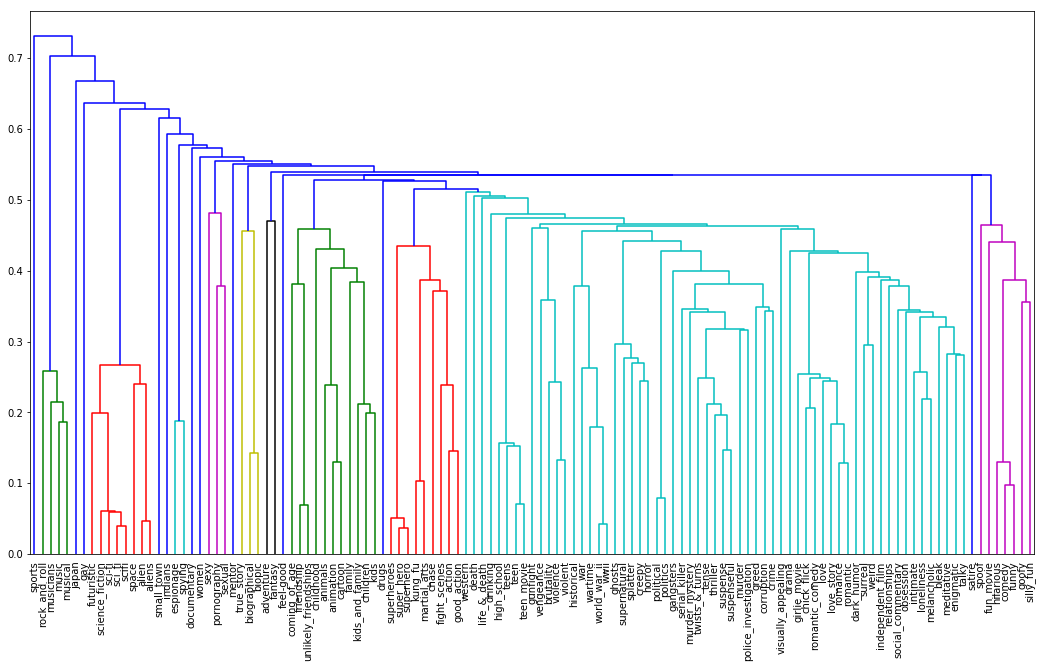

In [14]:
#get correlation matrix for each tag
corr = genome_tags.corr()

#change to distance matrix using 
corr = 1- corr
corr.head()

cond_dist = squareform(corr)

Z = linkage(cond_dist)
fig, ax = plt.subplots(figsize=(18, 10))
g = dendrogram(Z, ax = ax, labels=corr.index)
ax.tick_params(axis = 'x', which = 'major', labelsize = 10)
plt.show()

In [15]:
cutree = cut_tree(Z, height = 0.40)
cutree = np.reshape(cutree, -1)

In [16]:
var_clusters = pd.DataFrame({'tag' : corr.index,
                            'cluster': cutree})
var_clusters.sort_values(by = 'cluster')
cluster_tags = {
    0: 'action',
    1: 'adventure',
    2: 'scifi',
    3: 'animation',
    4: 'biopic',
    5: 'melancholic_wierd',
    6: 'violent',
    7: 'romance',
    8: 'childhood', 
    9: 'family',
    10: 'comedy', 
    11: 'friendships', 
    12: 'crime',
    13: 'horror', 
    14: 'death', 
    15: 'documentary', 
    16: 'drama', 
    17: 'drugs', 
    18: 'drinking',
    19: 'spy',
    20: 'fantasy', 
    21: 'feel_good',
    22: 'fun', 
    23: 'gangsters', 
    24: 'gay',
    25: 'gunfight',
    26: 'teen', 
    27: 'war',
    28: 'indians', 
    29: 'japan', 
    30: 'life_death',
    31: 'mentor', 
    32: 'music', 
    33: 'political', 
    34: 'sexual', 
    35: 'satire', 
    36: 'sexy', 
    37: 'smalltown', 
    38: 'spoof', 
    39: 'sports', 
    40: 'superhero', 
    41: 'true story', 
    42: 'visual',
    43: 'western',
    44: 'women'
}

topics = list(cluster_tags.values())

In [17]:
genome_tags = pd.melt(genome_tags.reset_index(), id_vars = 'movieId', var_name='tag', value_name='relevance')
genome_tags = genome_tags.merge(var_clusters, left_on = 'tag', right_on = 'tag', how = "left")
genome_tags = pd.DataFrame(genome_tags.groupby(['movieId', 'cluster'])['relevance'].max()).reset_index()
genome_tags['cluster_label'] = genome_tags.cluster.map(cluster_tags)
genome_tags = genome_tags.pivot(index='movieId', columns='cluster_label', values='relevance')

In [18]:
genome_tags = genome_tags.merge(movies[['title', 'tmdbId', 'movieId']] , left_index = True, right_on = 'movieId', how = 'left')

In [19]:
genome_tags.head()

,action,adventure,animation,biopic,childhood,comedy,crime,death,documentary,drama,...,teen,true story,violent,visual,war,western,women,title,tmdbId,movieId
0,0.65025,0.89800,0.98650,0.11625,0.92350,0.68525,0.47850,0.19825,0.03175,0.35025,...,0.22500,0.10700,0.29325,0.40675,0.16225,0.02275,0.10850,Toy Story (1995),862,1
1,0.64625,0.97975,0.91150,0.08475,0.86725,0.52800,0.39800,0.35350,0.02450,0.23900,...,0.23225,0.09750,0.24825,0.18850,0.04625,0.01275,0.12750,Jumanji (1995),8844,2
2,0.53900,0.42900,0.09125,0.04350,0.34375,0.85275,0.35350,0.38525,0.01950,0.18425,...,0.16775,0.06425,0.46375,0.21950,0.06600,0.03500,0.37375,Grumpier Old Men (1995),15602,3
3,0.27875,0.12975,0.13075,0.03175,0.24650,0.14225,0.19325,0.22925,0.03225,0.26875,...,0.25725,0.08575,0.38275,0.18425,0.06400,0.03000,0.97575,Waiting to Exhale (1995),31357,4
4,0.58650,0.15250,0.12850,0.05625,0.35625,0.91625,0.25225,0.22350,0.01850,0.30400,...,0.16150,0.06800,0.30775,0.19375,0.05700,0.02400,0.46200,Father of the Bride Part II (1995),11862,5


In [20]:
genome_tags_binary = genome_tags.drop(['title', 'tmdbId', 'movieId'], axis = 1) > 0.75
genome_tags_binary[['movieId', 'title', 'tmdbId']] = genome_tags[['movieId','title', 'tmdbId']]
genome_tags_binary[topics] = genome_tags_binary[topics] *1
genome_tags_binary.head()

,action,adventure,animation,biopic,childhood,comedy,crime,death,documentary,drama,...,teen,true story,violent,visual,war,western,women,movieId,title,tmdbId
0,False,True,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,1,Toy Story (1995),862
1,False,True,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,2,Jumanji (1995),8844
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,3,Grumpier Old Men (1995),15602
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,4,Waiting to Exhale (1995),31357
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,5,Father of the Bride Part II (1995),11862


In [61]:
genome_tags_binary[topics].sum(axis = 0).sort_values(ascending = False)

melancholic_wierd    3641.0
crime                2260.0
comedy               1605.0
action               1535.0
violent              1265.0
romance              1235.0
mentor               1228.0
drama                1072.0
horror               1037.0
visual                843.0
family                822.0
scifi                 706.0
war                   643.0
sexual                638.0
fun                   627.0
friendships           624.0
teen                  617.0
animation             578.0
childhood             548.0
music                 494.0
adventure             425.0
documentary           383.0
true story            360.0
feel_good             357.0
political             355.0
gunfight              344.0
life_death            319.0
biopic                312.0
gangsters             297.0
sexy                  293.0
fantasy               290.0
drugs                 275.0
death                 260.0
women                 255.0
spy                   246.0
smalltown           

In [22]:
genome_tags_binary[topics].sum(axis = 1).mean()

2.615734838827172

In [23]:
import time
import collections
from PIL import Image
import sys

def get_rgb(url):
    try:
        resp = requests.get(url, stream=True).raw
        
    except requests.exceptions.RequestException as e:  
        sys.exit(1)
        
    try:
        img = Image.open(resp)
        
    except IOError:
        print("Unable to open image")
        sys.exit(1)
        
    #translate to rgb array; shape = rows x columns x channels
    image_rgb = np.array(img)
    
    return image_rgb

posters = collections.defaultdict(dict)
for i in genome_tags_binary['tmdbId']:
    try:
        #api call to get movie poster path
        movie = tmdb.Movies(i)
        movie.info()
    
    except requests.exceptions.HTTPError:
        print("tmbdId %s doesn't exist" %i)
        posters[i]['tmdbId_exist'] = 0
        continue
    
    else:
        posters[i]['tmdbId_exist'] = 1
        posters[i]['poster_path'] = movie.info()['poster_path']
        posters[i]['title'] = movie.info()['title']

tmbdId 68149 doesn't exist
tmbdId 24549 doesn't exist
tmbdId 14980 doesn't exist
tmbdId 164721 doesn't exist
tmbdId 140207 doesn't exist
tmbdId 192936 doesn't exist
tmbdId 876 doesn't exist
tmbdId 149645 doesn't exist
tmbdId 8677 doesn't exist
tmbdId 13057 doesn't exist
tmbdId 119324 doesn't exist
tmbdId 2670 doesn't exist
tmbdId 13519 doesn't exist
tmbdId 152426 doesn't exist
tmbdId 30983 doesn't exist
tmbdId 7096 doesn't exist
tmbdId 15738 doesn't exist
tmbdId 11944 doesn't exist
tmbdId 110147 doesn't exist
tmbdId 206216 doesn't exist
tmbdId 64699 doesn't exist
tmbdId 69234 doesn't exist
tmbdId 13716 doesn't exist
tmbdId 11343 doesn't exist
tmbdId 10700 doesn't exist
tmbdId 24019 doesn't exist
tmbdId 58923 doesn't exist
tmbdId 17266 doesn't exist
tmbdId 253768 doesn't exist
tmbdId 27138 doesn't exist
tmbdId 14305 doesn't exist
tmbdId 13541 doesn't exist
tmbdId 225130 doesn't exist
tmbdId 114796 doesn't exist
tmbdId 13905 doesn't exist
tmbdId 14301 doesn't exist
tmbdId 67479 doesn't e

In [24]:
posters_df = pd.DataFrame.from_dict(posters, orient = 'index')
posters_df.loc[posters_df['poster_path'].notnull(), 'full_path'] = "https://image.tmdb.org/t/p/w300" + posters_df['poster_path']
posters_df.loc[posters_df['poster_path'].notnull(), 'rgb'] = posters_df.loc[posters_df['poster_path'].notnull(),'full_path'].apply(get_rgb)
posters_df['size'] = posters_df['rgb'].apply(np.shape)
posters_df.index.rename('tmdbId', inplace = True)
posters_df.reset_index(inplace = True)

In [ ]:
with open('posters_url.pickle', 'wb') as handle:
    pickle.dump(posters_df[['tmdbId', 'tmdbId_exist', 'title', 'full_path']], handle, protocol=pickle.HIGHEST_PROTOCOL)

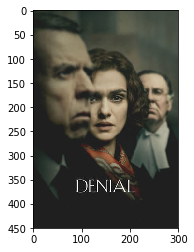

In [46]:
#plt.imshow(posters_df['rgb'][10960])
#posters_df.head()

In [62]:
posters_df = pd.merge(posters_df, genome_tags_binary[['tmdbId'] + topics], left_on = 'tmdbId', right_on = 'tmdbId', how = 'left')

In [65]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

from sklearn.model_selection import train_test_split

In [227]:
sized = posters_df[posters_df['size'] == (450, 300, 3)]

x_train, x_test, y_train, y_test = train_test_split(sized['rgb'], 
                                                    sized['action'],
                                                    test_size=0.33, random_state=42)

In [236]:
x_train = np.stack(x_train.values)
x_test = np.stack(x_test.values)

In [237]:
batch_size = 128
num_classes = 1
epochs = 10

# input image dimensions
img_x, img_y = 450, 300

# load the MNIST data set, which already splits into train and test sets for us
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 3)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 3)
input_shape = (img_x, img_y, 3)

# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (6476, 450, 300, 3)
6476 train samples
3191 test samples


In [241]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(50, 50), strides=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(9, 9), strides=(2, 2)))
model.add(Conv2D(64, (10, 10), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Train on 6476 samples, validate on 3191 samples
Epoch 1/10
6476/6476 [==============================] - 922s 142ms/step - loss: 13.5372 - acc: 0.1509 - val_loss: 13.5892 - val_acc: 0.1476
Epoch 2/10
6476/6476 [==============================] - 904s 140ms/step - loss: 13.5372 - acc: 0.1509 - val_loss: 13.5892 - val_acc: 0.1476
Epoch 3/10
6476/6476 [==============================] - 923s 143ms/step - loss: 13.5372 - acc: 0.1509 - val_loss: 13.5892 - val_acc: 0.1476
Epoch 4/10
6272/6476 [============================>.] - ETA: 24s - loss: 13.5505 - acc: 0.1500

KeyboardInterrupt: 

In [ ]:
from keras.models import Sequential
from scipy.misc import imread
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

from sklearn.metrics import log_loss

train=pd.read_csv("R/Data/Train/train.csv")
test=pd.read_csv("R/Data/test.csv")
train_path="R/Data/Train/Images/train/"
test_path="R/Data/Train/Images/test/"

from scipy.misc import imresize

train_img=[]
for i in range(len(train)):

    temp_img=image.load_img(train_path+train['filename'][i],target_size=(224,224))

    temp_img=image.img_to_array(temp_img)

    train_img.append(temp_img)

train_img=np.array(train_img) 
train_img=preprocess_input(train_img)

test_img=[]
for i in range(len(test)):

temp_img=image.load_img(test_path+test['filename'][i],target_size=(224,224))

    temp_img=image.img_to_array(temp_img)

    test_img.append(temp_img)

test_img=np.array(test_img) 
test_img=preprocess_input(test_img)


from keras.models import Model

def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):

    model = VGG16(weights='imagenet', include_top=True)

    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-1].outbound_nodes = []

          x=Dense(num_classes, activation='softmax')(model.output)

    model=Model(model.input,x)

#To set the first 8 layers to non-trainable (weights will not be updated)

          for layer in model.layers[:8]:

       layer.trainable = False

# Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

train_y=np.asarray(train['label'])

le = LabelEncoder()

train_y = le.fit_transform(train_y)

train_y=to_categorical(train_y)

train_y=np.array(train_y)

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.2, random_state=42)

# Example to fine-tune on 3000 samples from Cifar10

img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_classes = 10 
batch_size = 16 
nb_epoch = 10

# Load our model
model = vgg16_model(img_rows, img_cols, channel, num_classes)

model.summary()
# Start Fine-tuning
model.fit(X_train, Y_train,batch_size=batch_size,epochs=nb_epoch,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid))

# Make predictions
predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

# Cross-entropy loss score
score = log_loss(Y_valid, predictions_valid)